<a href="https://colab.research.google.com/github/OlgaPuntous/Topic-modeling-with-North-Face/blob/master/North_Face_NLP_topic_extraction_and_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project of improving the structure of the products catalog thanks to topic extraction for North Face e-commerce


In [3]:
# Install spacy 
## -q is for "quiet". It removes logs 
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install wordcloud -q

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
# Import spacy, if you don't have it --> !pip install spacy 
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import wordcloud

nlp = en_core_web_sm.load()

## Preprocessing of textual data

In [5]:
def cleaning(df):

    df =df.str.replace(r'http\S+', " ") #removing internet links from text 
    df =df.str.replace(r"\S*@\S*\s?",' ')#removing email adresses from text 
    df = df.str.replace('[^\w\s]',' ')#keeping only alphanumeric characters
    df = df.str.replace("#", " ")#converting tags to text
    df = df.str.replace('\d+', '')#removing digits from text
    df = df.str.replace(" +", " ")
    #df = df.str.replace(r"[^A-Za-z0-9 ]+", " ") 
    df = df.fillna('').apply(lambda x: x.lower())
    df = df.str.split(' ').map(lambda x: " ".join(s for s in x if len(s) > 2))

    return (df)

def lemmatize_text(text): #need to lemmatize the text before converting it to the vectors.
    
      text = ''.join(ch for ch in text if ch.isalnum() or ch==" ")
      text = text.replace(" +"," ").lower().strip()
      text=nlp(text)
      lemma = ' '.join([token.lemma_ for token in text if token.lemma_ not in STOP_WORDS])
    
    
      return lemma

In [6]:
df=pd.read_csv('/sample-data_North_Face.csv')
df=df.drop('id',axis=1)
df.sample(2)

,description
233,Vitaliti dress - The ocean has had its way wit...
243,Print kupala top - Our fixed triangle bikini t...


In [7]:
lemmatize_text('Duck pants - long - Essential')

'duck pant   long   essential'

In [8]:
df['clean_token'] = cleaning(df["description"].apply(lambda x: lemmatize_text(str(x))))

In [9]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
vocabulary=vectorizer.vocabulary_
len(vocabulary)

5227

In [11]:
a = sorted(vocabulary.items(), key=lambda x: x[1],reverse=True)    
print(a)

[('zonesli', 5226), ('zone', 5225), ('zipthrough', 5224), ('zipsecurity', 5223), ('zippocket', 5222), ('zippingli', 5221), ('zippersliulbrbrbfabric', 5220), ('zippersli', 5219), ('zippers', 5218), ('zipperli', 5217), ('zipperedorganizer', 5216), ('zippered', 5215), ('zipper', 5214), ('zipped', 5213), ('zipoff', 5212), ('zipneck', 5211), ('zipli', 5210), ('zipflyseparating', 5209), ('zip', 5208), ('zinger', 5207), ('zest', 5206), ('yvon', 5205), ('young', 5204), ('youbrbrbdetailsbul', 5203), ('yosemite', 5202), ('yokeliulbrbrbfabric', 5201), ('yokeli', 5200), ('yoke', 5199), ('yoga', 5198), ('yjoint', 5197), ('yield', 5196), ('yearround', 5195), ('year', 5194), ('yarnsli', 5193), ('yarns', 5192), ('yarndye', 5191), ('yarn', 5190), ('yardbrbrbdetailsbul', 5189), ('yak', 5188), ('wyome', 5187), ('wwwpatagoniacomfishe', 5186), ('wroblewski', 5185), ('wristbandliulbrbrbfabric', 5184), ('wrist', 5183), ('wrinkleresistant', 5182), ('wrinklefree', 5181), ('wrinklebeate', 5180), ('wrinkle', 517

In [12]:
data=pd.DataFrame(dense,columns=[x for x in vectorizer.get_feature_names()])
data.describe()

,abandon,ability,able,aboveknee,abovetheknee,abrasion,abrasionli,abrasionresistance,abrasionresistant,abrasive,abrbrbdetailsbul,abroad,absolute,absorb,absorption,abstract,abuse,abusive,accentuate,access,accessedli,accessibility,accessli,accessory,accommodate,accomplish,accord,ace,achieve,achille,act,action,actioninspired,active,activefriendly,activeminde,activities,activity,acutely,adapt,...,wyome,yak,yardbrbrbdetailsbul,yarn,yarndye,yarns,yarnsli,year,yearround,yield,yjoint,yoga,yoke,yokeli,yokeliulbrbrbfabric,yosemite,youbrbrbdetailsbul,young,yvon,zest,zinger,zip,zipflyseparating,zipli,zipneck,zipoff,zipped,zipper,zippered,zipperedorganizer,zipperli,zippers,zippersli,zippersliulbrbrbfabric,zippingli,zippocket,zipsecurity,zipthrough,zone,zonesli
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.000315,0.000644,0.000303,0.000231,0.000254,0.004045,0.001055,0.000279,0.001591,0.000234,0.000202,0.000325,0.000348,0.000204,0.000390,0.000375,0.001729,0.000747,0.000284,0.003568,0.000247,0.000306,0.001535,0.001490,0.004066,0.000527,0.000816,0.000341,0.000274,0.000255,0.000583,0.001740,0.000289,0.005424,0.000307,0.000330,0.000301,0.003169,0.000389,0.000458,...,0.000625,0.000313,0.000362,0.005309,0.002093,0.014149,0.000304,0.004504,0.000933,0.000597,0.000936,0.001962,0.005052,0.001102,0.000199,0.000916,0.000287,0.000287,0.000413,0.000363,0.000194,0.017044,0.000444,0.000476,0.000644,0.001506,0.000214,0.026432,0.012099,0.000205,0.002671,0.000206,0.001562,0.000301,0.000447,0.000338,0.000255,0.001335,0.001813,0.001541
std,0.007045,0.008397,0.006783,0.005167,0.005685,0.016666,0.010543,0.006245,0.010588,0.005232,0.004518,0.007266,0.007771,0.004565,0.006209,0.008389,0.012630,0.009639,0.006342,0.017568,0.005513,0.006848,0.010087,0.014803,0.021627,0.005877,0.014185,0.007633,0.006131,0.005708,0.009206,0.013701,0.006461,0.026372,0.006870,0.007385,0.006728,0.019466,0.008698,0.007235,...,0.013975,0.006998,0.008098,0.021569,0.021995,0.041715,0.006797,0.023786,0.012017,0.007701,0.008665,0.014669,0.028427,0.012316,0.004451,0.016895,0.006408,0.006411,0.009231,0.008111,0.004349,0.042094,0.007012,0.007524,0.008312,0.018532,0.004790,0.050590,0.030959,0.004592,0.015621,0.004605,0.012399,0.006737,0.007064,0.007556,0.005695,0.015051,0.012979,0.012441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

## Identifying groups of products that have similar descriptions with DBScan:

In [13]:
# Instanciating DBSCAN 
db = DBSCAN(eps=0.59, min_samples=4, metric="cosine", algorithm="brute")
# Fiting on data 
db.fit(data)

DBSCAN(algorithm='brute', eps=0.59, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

In [14]:
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, 24, -1, -1, -1, -1, -1, -1,  0,  0, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  2,  3,  3, -1, -1,  4,  5, -1,  5,
        6,  2,  7, -1, -1, -1,  2, -1,  0,  0, -1, -1, -1,  8, -1, -1, -1,
       -1, -1, -1, -1,  2, -1,  2, -1,  1, -1, -1,  2,  2,  2, -1, -1,  2,
        8, -1,  2,  2,  2, -1,  9, -1,  9, -1, 10, 10, 10, -1, -1, -1, 11,
       -1, 12, 12, 12, 12, -1, -1, -1, -1,  2, 13, 14,  2, -1, -1, -1,  2,
       -1,  4, -1, 15, 11, 16, 16, 16, -1, -1, 17, 17, -1,  2, 18, -1, -1,
       -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17,
       -1,  2,  2, -1, 11, -1, -1,  2, -1, -1, 14, 10, 29, 19, -1,  2, 19,
       19, -1, -1, -1, -1, -1, 20, 20, -1, -1, -1, 21, 20,  2, 27,  2,  2,
        1,  1,  1,  1,  1,  1, -1,  2,  6, -1, -1, -1, -1, -1,  2, -1, 22,
       22, 23, 23, 23, -1, -1, -1,  9, 18, 11, -1, -1, 12, 12, 12, 12, 26,
       -1, -1, -1, -1, 14, 13, -1, 11, -1, -1, -1, -1, -1, -1, 24, 24, 25,
       25, 22, 22, -1,  9

In [15]:
df['db_cluster']=db.labels_
print('number of identified clusters: ',df['db_cluster'].nunique())

number of identified clusters:  31


In [16]:
#Example of similar items:
df[df['db_cluster']==10]

,description,clean_token,db_cluster
78,Lw endurance ankle socks - Fast-forward pursui...,endurance ankle sock fastforward pursuit like ...,10
79,"Lw endurance quarter socks - Scraped, taped or...",endurance quarter sock scrape tape inflame pro...,10
80,Lw hiking crew socks - Like suites for your fe...,hiking crew sock like suite pron foot staycool...,10
147,Ulw hiking crew socks - The heat along the Bou...,ulw hiking crew sock heat boucher trail shut p...,10
337,Ultra hw mountaineering socks - Every weather ...,ultra mountaineering socks weather window shut...,10
338,Ultra lw endurance ped socks - Socks for fiery...,ultra endurance ped sock sock fiery day shade ...,10
456,Mw hiking crew socks - Mount Mendel's Ice Nine...,hiking crew socks mount mendels ice long footj...,10


## Topic modeling with TruncatedSVD to automatically assess the latent topics present in the item descriptions.

In [23]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(data)

In [24]:
col=[]
for i in range(1,11):
    col.append('topic_{}'.format(i))

topic_encoded_df = pd.DataFrame(lsa, columns = col)
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.252590,-0.042113,0.129540,0.111035,-0.114558,-0.009584,-0.033578,0.017083,0.057022,-0.134866
1,0.229403,-0.054069,0.060301,0.088410,-0.031442,0.046572,-0.014323,-0.014130,-0.020065,-0.093670
2,0.200659,-0.051944,0.057967,0.036374,-0.040585,0.044900,0.034987,-0.021545,-0.075782,-0.057516
3,0.314552,-0.199871,-0.125229,-0.093858,0.029224,-0.042164,-0.124611,0.035321,-0.001703,-0.062717
4,0.353998,-0.246968,-0.035428,-0.192950,-0.051425,-0.076357,0.004517,0.048714,-0.074437,-0.002226
...,...,...,...,...,...,...,...,...,...,...
495,0.327518,-0.092634,0.322871,0.102363,-0.305632,-0.077134,-0.027034,-0.001857,0.122243,-0.329144
496,0.366143,-0.095641,0.405463,0.034376,-0.353713,-0.064518,0.068181,0.043752,0.072521,-0.232932
497,0.290725,-0.195297,-0.063764,-0.214348,-0.006019,-0.222883,-0.003812,-0.130935,0.015769,0.071516
498,0.273241,0.105360,-0.151640,0.295418,0.105863,-0.075634,-0.071588,0.133586,0.077259,-0.045177


In [25]:
topic_encoded_df['text']=df['clean_token']
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,text
0,0.252590,-0.042113,0.129540,0.111035,-0.114558,-0.009584,-0.033578,0.017083,0.057022,-0.134866,active classic boxer reason pron boxer cult fa...
1,0.229403,-0.054069,0.060301,0.088410,-0.031442,0.046572,-0.014323,-0.014130,-0.020065,-0.093670,active sport boxer brief skin glory require mo...
2,0.200659,-0.051944,0.057967,0.036374,-0.040585,0.044900,0.034987,-0.021545,-0.075782,-0.057516,active sport brief superbreathable nofly brief...
3,0.314552,-0.199871,-0.125229,-0.093858,0.029224,-0.042164,-0.124611,0.035321,-0.001703,-0.062717,alpine guide pant skin climb ice switch rock t...
4,0.353998,-0.246968,-0.035428,-0.192950,-0.051425,-0.076357,0.004517,0.048714,-0.074437,-0.002226,alpine wind jkt high ridge steep ice alpine ja...
...,...,...,...,...,...,...,...,...,...,...,...
495,0.327518,-0.092634,0.322871,0.102363,-0.305632,-0.077134,-0.027034,-0.001857,0.122243,-0.329144,cap cut loose madden crowd search undone capil...
496,0.366143,-0.095641,0.405463,0.034376,-0.353713,-0.064518,0.068181,0.043752,0.072521,-0.232932,cap crew crew edge fickle weather clearing con...
497,0.290725,-0.195297,-0.063764,-0.214348,-0.006019,-0.222883,-0.003812,-0.130935,0.015769,0.071516,alltime shell need use morning time umbrella a...
498,0.273241,0.105360,-0.151640,0.295418,0.105863,-0.075634,-0.071588,0.133586,0.077259,-0.045177,allwear cargo short allwear cargo short bask g...


In [26]:
indexes=[topic_encoded_df['topic_{}'.format(i)].idxmax() for i in range(1,11)]

In [27]:
indexes

[14, 490, 259, 462, 265, 261, 68, 353, 68, 477]

## Here there are our topics:

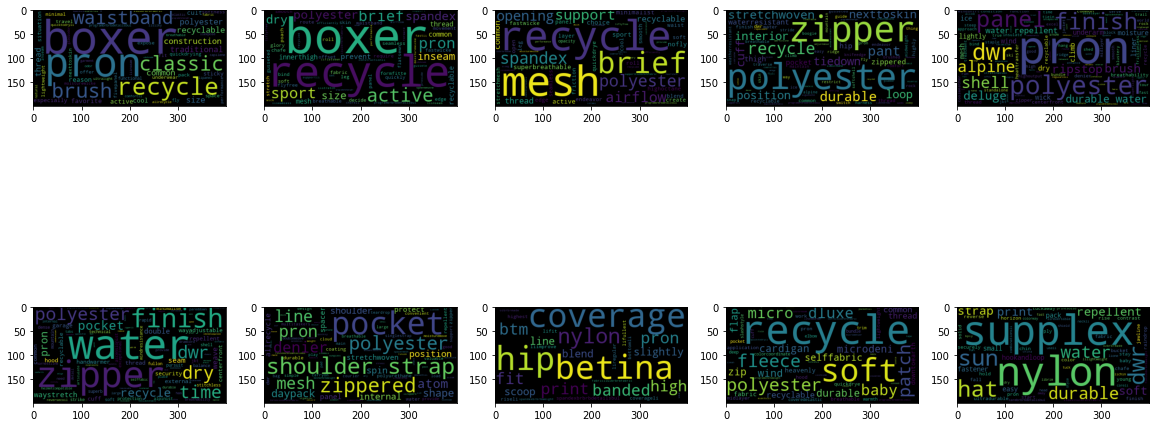

In [28]:
fig,ax=plt.subplots(2,5,figsize=(20,10))

for i,axi in enumerate(ax.flat):
    str=topic_encoded_df.text[i]
    doc=nlp(str)
    wd = wordcloud.WordCloud()
    cloud = wd.generate(doc.text)
    axi.imshow(cloud)
